# Training Model

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import data

In [2]:
file_name_all_data = "data/_nanocomposite_data.csv"
all_data = pd.read_csv(file_name_all_data, index_col=None, header=0)
# Drop columns which are not used for now
all_data_clean = all_data.drop(
    ["polymer_p2", "ratio_1_2", "filler_2", "wt_l2", "owner", "foaming"],
    axis=1,
)  # , inplace=True
all_data_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,HDPEtreated,GNP,13.937781,4.838375
1,HDPEtreated,GNP,2.289694,0.086995
2,HDPEtreated,GNP,13.353691,5.111546
3,HDPEtreated,GNP,23.393479,14.008136
4,HDPEtreated,GNP,16.255365,5.732612


## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [3]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.get_params()

{'clip': False, 'copy': True, 'feature_range': (0, 1)}

### The Y label is highly variation
The Y label is the electrical conductivity which is extremely low before the threhold and sudenly increases once the amount of fillers passes the threshold. In this study, the Y values fall mostly in to the range of [1e-3, 1e3], hence, the graph is scaled logarithmically in y-axis.

In [4]:
def safe_log10(data):
    """Handle LOG safely in cases of too small values close or equal to 0.

    Parameters
    ----------
    data : {array-like, sparse matrix} of shape (n_samples, n_features)
        Input data.

    Returns
    -------
    data: np.Array[float]
        {array-like, sparse matrix} of shape (n_samples, n_features)
    """
    prob_tmp = np.where(data > 1.0e-10, data, 1.0e-10)
    result = np.where(data > 1.0e-10, np.log10(prob_tmp), -10)
    return result


class SuperHighVariationScaler:
    """Create a wrapper for different scalers."""

    scaler: StandardScaler

    def __init__(self, scaler=None):
        """Initialize if scaler is given.

        Parameters
        ----------
        scaler : Scaler, optional
            Include StandardScaler, MinMaxScaler
            from sklearn.preprocessing, by default StandardScaler
        """
        if scaler is not None:
            self.scaler = scaler
        else:
            self.scaler = StandardScaler()

    def fit_transform(self, data):
        """Fit then transform data.

        Parameters
        ----------
        data : Array[float]
            Input data.
            {array-like, sparse matrix} of shape (n_samples, n_features)

        Returns
        -------
        data: Array[float]
            Transformed data.
            {ndarray, sparse matrix} of shape (n_samples, n_features)
        """
        data_loged = safe_log10(data)
        return self.scaler.fit_transform(data_loged)

    def transform(self, data):
        """Transform data."""
        data_loged = safe_log10(data)
        return self.scaler.transform(data_loged)

    def inverse_transform(self, data):
        """Inverse transform data to get real value (before transformed)."""
        data_unloged = self.scaler.inverse_transform(data)
        return np.float_power(10, data_unloged)


Y_scaler = SuperHighVariationScaler()  #

You can try other Scaler
```python
Y_scaler = SuperHighVariationScaler( 
                    MinMaxScaler(feature_range=(0, 1)) 
                    )
Y_scaler.Scaler.get_params()
```

### Mapping not Numeric Values / Columns

In [5]:
def map_string_to_num(data):
    """Map string to number: Change text ID to index ID of material.

    Parameters
    ----------
    data : _type_
        Input data.

    Returns
    -------
    _type_
        Change fields of data which are string to number.
    """
    polymer_map_list = {"HDPE": 0, "HDPEtreated": 1}
    filler_map_list = {"MWCNT": 0, "SWCNT": 1, "GNP": 2}
    data["polymer_1"] = data["polymer_1"].map(polymer_map_list)
    data["filler_1"] = data["filler_1"].map(filler_map_list)
    return data


def map_num_to_string(data):
    """Map number to string: Change index to text ID of material.

    Parameters
    ----------
    data : _type_
        Input data.

    Returns
    -------
    _type_
        Change fields of data which are number to string.
    """
    # inversed_map = {v: k for k, v in polymer_map_list.items()}
    polymer_map_list = {0: "HDPE", 1: "HDPEtreated"}
    filler_map_list = {0: "MWCNT", 1: "SWCNT", 2: "GNP"}
    data["polymer_1"] = data["polymer_1"].map(polymer_map_list)
    data["filler_1"] = data["filler_1"].map(filler_map_list)
    return data


all_data_clean = map_string_to_num(all_data_clean)
all_data_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,1,2,13.937781,4.838375
1,1,2,2.289694,0.086995
2,1,2,13.353691,5.111546
3,1,2,23.393479,14.008136
4,1,2,16.255365,5.732612


### Splitting data to training and testing sets

In [6]:
training_data, testing_data = train_test_split(
    all_data_clean, test_size=0.2, random_state=25
)  # , random_state=25
print(len(training_data), "train examples")
print(len(testing_data), "test examples")
training_data.head()

4000 train examples
1000 test examples


,polymer_1,filler_1,wt_l1,conductivity
1464,1,0,21.298200,205.818866
1394,1,0,9.820779,44.843086
4738,0,1,16.620847,266.764742
2913,0,2,24.921567,1.025940
1757,1,0,3.027726,3.549664


In [7]:
# Split into input features (X) and output labels (Y) variables
X_training = training_data.drop("conductivity", axis=1).values
Y_training = training_data[["conductivity"]].values

# Pull out columns for X (data to train with) and Y (value to predict)
X_testing = testing_data.drop("conductivity", axis=1).values
Y_testing = testing_data[["conductivity"]].values

### Scaling data

In [8]:
# Scale both the training inputs and outputs
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# It's very important that the training and test data are scaled 
#   with the same scaler.
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

# Model build and complie

## batch_size: 
Too large of a batch size will lead to poor generalization

Smaller batch sizes could shown to have faster convergence to “good” solutions. 

In [9]:
# Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
    metrics=tf.keras.metrics.MeanSquaredLogarithmicError(),
)

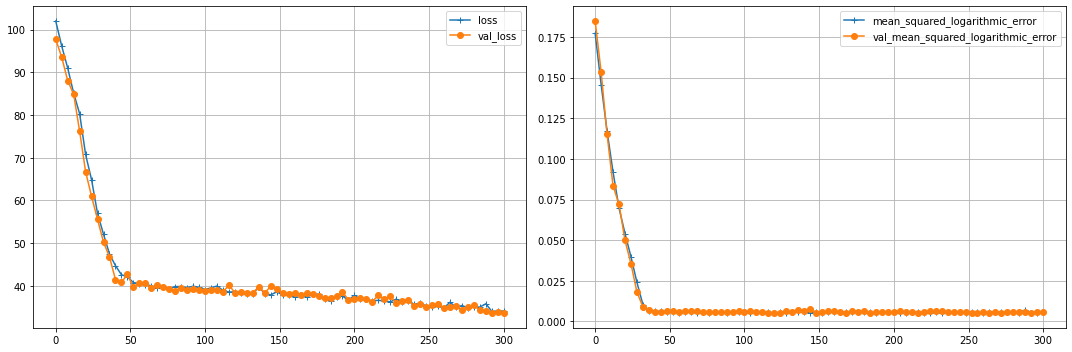

Training is done!


In [10]:
# import PlotRealTime to plot Loss vs Epochs while fitting
from functions import PlotRealTime

epochs = 300
batch_size = 64
step_display = 5 if epochs < 100 else (epochs // 100 + 1)

callbacks_list = [PlotRealTime(step=step_display)]
# More parameters
"""callbacks_list = [
    plotRealTime(step=step_display),
    earlyStopper(),
    reduceLR(),
    modelCheckpointCallback(),
]"""

history = model.fit(
    X_scaled_training,
    Y_scaled_training,
    validation_data=(X_scaled_testing, Y_scaled_testing),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks_list,
    verbose=0,
)
print("Training is done!")
if epochs != len(history.history["loss"]):
    print("Stopped early!")

In [11]:
print(history.params)

{'verbose': 0, 'epochs': 300, 'steps': 63}


In [12]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


## Plotting Training Results

In [13]:
# import smoothArray to smooth array (acts like Convolving signal with noise)
from functions import smooth_array

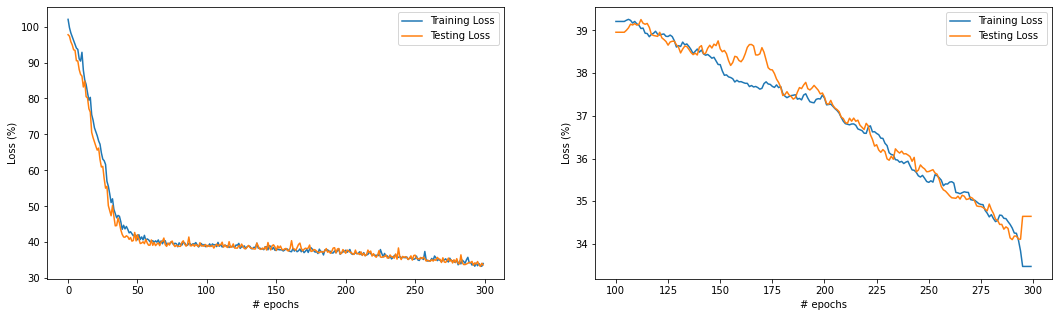

In [14]:
# Check if Stopped early
if epochs != len(history.history["loss"]):
    epochs = len(history.history["loss"])  # Only real epochs
x_zoom = 200
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
x_range = range(0, epochs)
ax1.plot(x_range, history.history["loss"], label="Training Loss")
ax1.plot(x_range, history.history["val_loss"], label="Testing Loss")
ax1.set(xlabel="# epochs", ylabel="Loss (%)")
ax1.legend()

ax2.plot(
    x_range[-x_zoom:],
    smooth_array(history.history["loss"][-x_zoom:]),
    label="Training Loss",
)
ax2.plot(
    x_range[-x_zoom:],
    smooth_array(history.history["val_loss"][-x_zoom:]),
    label="Testing Loss",
)
ax2.set(xlabel="# epochs", ylabel="Loss (%)")
ax2.legend()
plt.show()

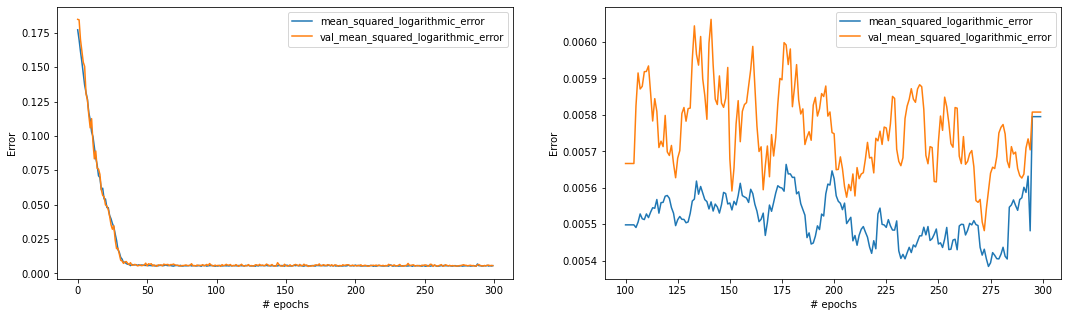

In [15]:
metrics = [x for x in history.history.keys() if "loss" not in x]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
x_range = range(0, epochs)
for metric in metrics:
    ax1.plot(x_range, history.history[metric], label=metric)
ax1.set(xlabel="# epochs", ylabel="Error")
ax1.legend()

for metric in metrics:
    ax2.plot(
        x_range[-x_zoom:],
        smooth_array(history.history[metric][-x_zoom:]),
        label=metric,
    )
ax2.set(xlabel="# epochs", ylabel="Error")
ax2.legend()
plt.show()

## Plotting predicting vs testing data

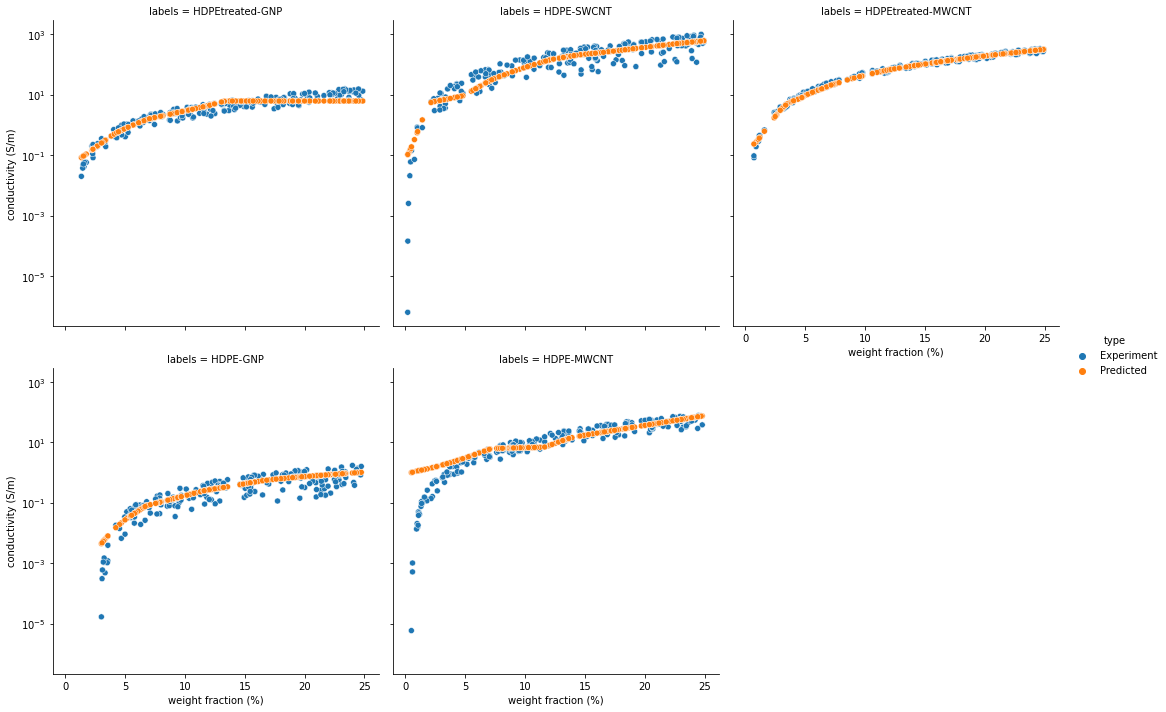

In [16]:
# Calculate predictions
predicted_value = model.predict(X_scaled_testing)
predicted_value = Y_scaler.inverse_transform(predicted_value)

complete_data = testing_data.copy()
complete_data = map_num_to_string(complete_data)

complete_data["labels"] = (
    complete_data["polymer_1"] + "-" + complete_data["filler_1"]
)
complete_data["type"] = "Experiment"
compdata2 = complete_data.copy()
compdata2["type"] = "Predicted"
compdata2["conductivity"] = predicted_value

complete_data = pd.concat([complete_data, compdata2], ignore_index=True)

g = sns.relplot(
    data=complete_data,
    x="wt_l1",
    y="conductivity",
    hue="type",
    col="labels",
    kind="scatter",
    col_wrap=3,
)
g.set_xlabels("weight fraction (%)")
g.set_ylabels("conductivity (S/m)")
g.set(yscale="log")
plt.show()

## Saving data

In [17]:
from pickle import dump

# Save the trained model to disk
# dump(model, open('model.pkl', 'wb'))
model.save("saved/predictor-conductivity-model")

# To be convenient, the SCALERs will be saved
dump(X_scaler, open("saved/X_scaler.pkl", "wb"))
dump(Y_scaler, open("saved/Y_scaler.pkl", "wb"))

INFO:tensorflow:Assets written to: saved/predictor-conductivity-model\assets


# Conclusion

## Results are acceptable
The difference between prediction and experiment is within one order of magnitude, which is acceptable.

## Issues
There are a strange behaviour at range around 5%. 

However, our data (conductivity) of different fillers is highly divergent. The carbon nanotube has much higher in intrisic conductivity, leading CNT-based composite has much higher electrical conductivity than the GNP one. Also, the values of threshold in cases of CNT-based composite are much smaller than GNP one. That why there is inconsistent area at 5%.

The X-axis might need scaling with different Scaler which prefers logarithmic scales.